In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K

import pylab as plt

from keras.datasets import mnist

from utiles import *

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# indentity AE
!for debuging purposes

W1115 14:03:17.701608 140099105408832 training_eager.py:274] The list of trainable weights is empty. Make sure that you are not setting model.trainable to False before compiling the model.


Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/3
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0000e+00

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/3
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0000e+00

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/3
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0000e+00
------------------------------------------------------------------------------------------
Encoded and decoded shapes are (1, 784), (1, 784).


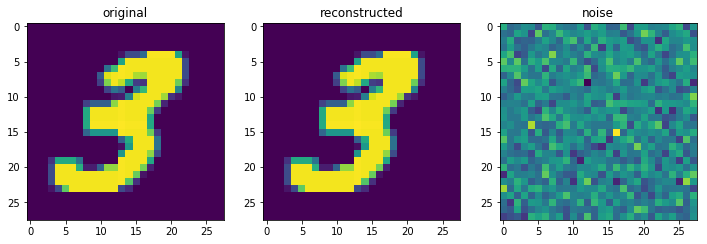

Differece between method and predicdt is 0.0.
------------------------------------------------------------------------------------------


In [3]:
aeb = AutoEncoderBase(input_dim=784,latent_dim=784,debug_mode=True)
aeb.check(x_train,l=28,w=28)

# Dense Auto Encoders

#### This function helps to make dens architectures.

In [5]:
def dense_arch(x_in,arch,activation,last_layer_activation=None,activity_regularizer=None):
    
    assert x_in.get_shape().as_list()[1]==arch[0],'The size of the input layer is not compatible with the first layer!'
    
    assert len(arch)>1,'Number of layers has to be more than 1!'
    
    if len(arch)==2:
        if last_layer_activation is None:
            x = Dense(arch[1],
                      activation=activation,
                      activity_regularizer=activity_regularizer)(x_in)
            return x
        else:
            x = Dense(arch[1],
                      activation=last_layer_activation,
                      activity_regularizer=activity_regularizer)(x_in)
            return x
    
    x = Dense(arch[1],
              activation=activation,
              activity_regularizer=activity_regularizer)(x_in)
    for i in arch[2:-1]:
        x = Dense(i,
                  activation=activation,
                  activity_regularizer=activity_regularizer)(x)
    if last_layer_activation is None:
        x = Dense(arch[-1],
                  activation=activation,
                  activity_regularizer=activity_regularizer)(x)
    else:
        x = Dense(arch[-1],
                  activation=last_layer_activation,
                  activity_regularizer=activity_regularizer)(x)
    return x


#### example:

In [5]:
x_in = Input(shape=(10))
y = dense_arch(x_in,[10,20,30,40],activation='relu')
model = Model(x_in,y)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1240      
Total params: 2,090
Trainable params: 2,090
Non-trainable params: 0
_________________________________________________________________


#### This class helps to make dense AEs

In [11]:
class DenseAutoEncoder(AutoEncoderBase):
    def __init__(self,
                 input_dim = None,
                 latent_dim = None,
                 network_architecture = None, 
                 activation = 'relu',
                 last_layer_activation = 'sigmoid',
                 activity_regularizer = None,
                 learning_rate = 0.03,
                 batch_size = 100):
        
        super().__init__(input_dim = input_dim,
                         latent_dim = latent_dim,
                         activation = activation,
                         activity_regularizer = activity_regularizer,
                         learning_rate = learning_rate,
                         batch_size = batch_size)
        
        if network_architecture is None:
            self.network_architecture = [ [self.input_dim,self.input_dim//2,self.latent_dim],
                                          [self.latent_dim,self.input_dim//2,self.input_dim] ]
        else:
            self.network_architecture = network_architecture
        
        self.encoder_arch = self.network_architecture[0]
        self.decoder_arch = self.network_architecture[1]
        self.input_dim = self.encoder_arch[0]
        self.latent_dim = self.encoder_arch[-1] 
        self.last_layer_activation = last_layer_activation
        
        assert len(self.encoder_arch)>1,'Encoder layers have to be more than 1!'
        assert len(self.decoder_arch)>1,'Decoder layers have to be more than 1!'
        assert self.encoder_arch[0]==self.decoder_arch[-1],\
                "Input and output dimension have to be equal in encoder and decoder!"
        assert self.encoder_arch[-1]==self.decoder_arch[0],\
                "Latent layer dimension have to be equal in encoder and decoder!"

        self.input = Input(shape=(self.input_dim))
        self.encoded = self._encode(self.input)
        self.decoded = self._decode(self.encoded)
        
        self.encoder_index = len(self.encoder_arch)
        
        self.prepare_models()
        
    def _encode(self, x_in):

        encoded = dense_arch(x_in,
                             arch = self.encoder_arch,
                             activation = self.activation,
                             activity_regularizer = self.activity_regularizer)

        return encoded
    
    def _decode(self, encoded):
        
        decoded = dense_arch(encoded,
                             arch = self.decoder_arch,
                             activation = self.activation,
                             last_layer_activation = self.last_layer_activation,
                             activity_regularizer = self.activity_regularizer)
        
        return decoded

Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.2255

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1342

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0756

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0729

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 5/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0723

Epoch 00006: LearningRateScheduler reducing learning rate to 0.003125.
Epoch 6/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0721
Epoch 00006: early stopping
----

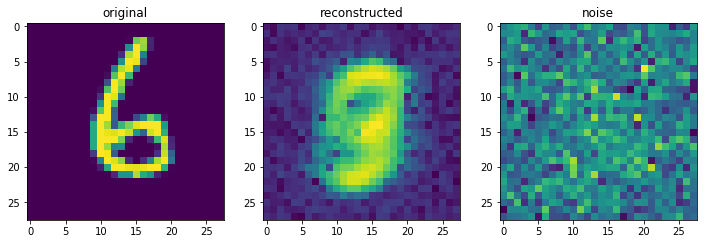

Differece between method and predicdt is 44.43859100341797.
------------------------------------------------------------------------------------------


In [7]:
dae = DenseAutoEncoder(network_architecture=[[784,100,32],[32,100,784]])
dae.check(x_train,l=28,w=28,training_epochs=10)

#### we can train and make an illustration

In [14]:
dae = DenseAutoEncoder(network_architecture=[[784,128,32,2],[2,32,128,784]])
dae.train(x_train,training_epochs=10)

Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/10
60000/60000 [==============================] - 3s 45us/sample - loss: 0.2296

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.2268

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.2251

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.2241
Epoch 00004: early stopping


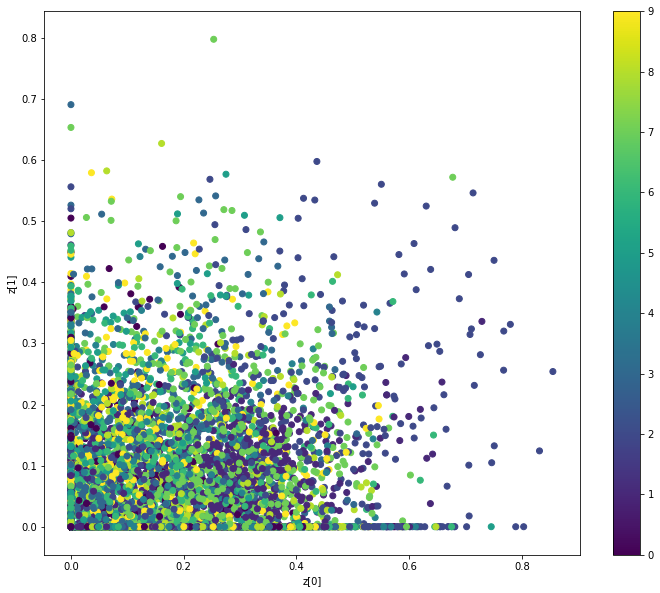

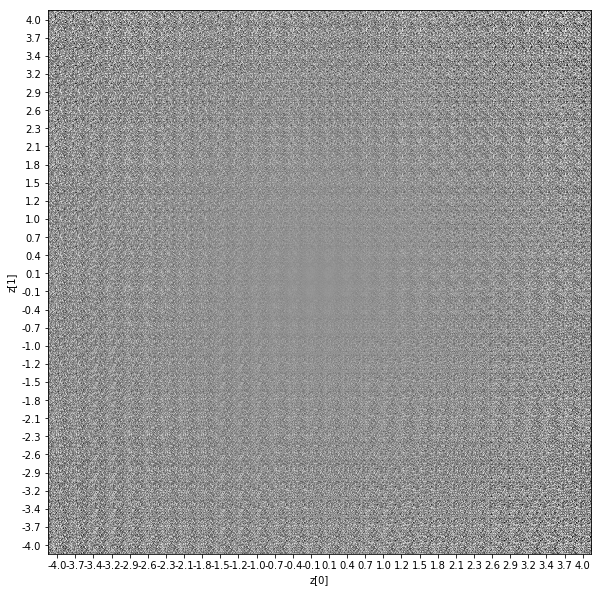

In [15]:
dae.illustration(data=(x_test,y_test))

#### Sparsity implimentation

In [26]:
sdae = DenseAutoEncoder(network_architecture=[[784,128,32,2],[2,32,128,784]],activity_regularizer=l2(0.01))
sdae.train(x_train,training_epochs=10)

Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/10
60000/60000 [==============================] - 3s 54us/sample - loss: 1.9247

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/10
60000/60000 [==============================] - 3s 49us/sample - loss: 0.7590

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/10
60000/60000 [==============================] - 3s 47us/sample - loss: 0.5750

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/10
60000/60000 [==============================] - 3s 44us/sample - loss: 0.5300

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 5/10
60000/60000 [==============================] - 3s 45us/sample - loss: 0.5121

Epoch 00006: LearningRateScheduler reducing learning rate to 0.003125.
Epoch 6/10
60000/60000 [==============================] - 3s 45us/sample - loss: 0.5041

Epoch 00007: LearningRateSchedu

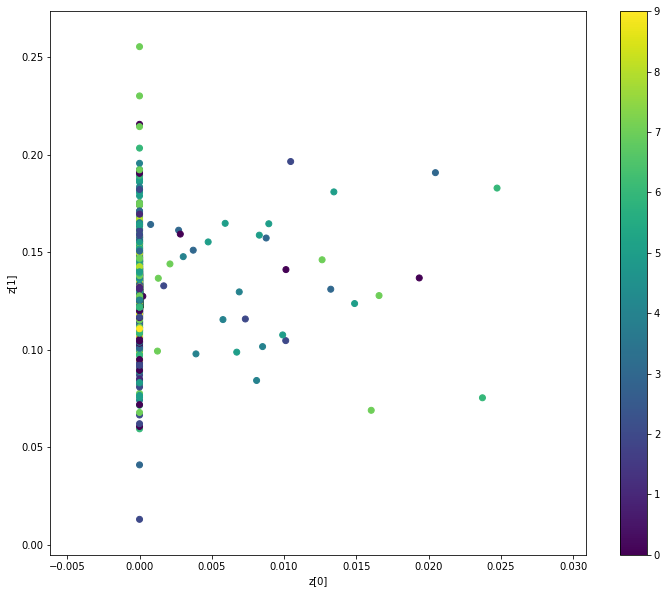

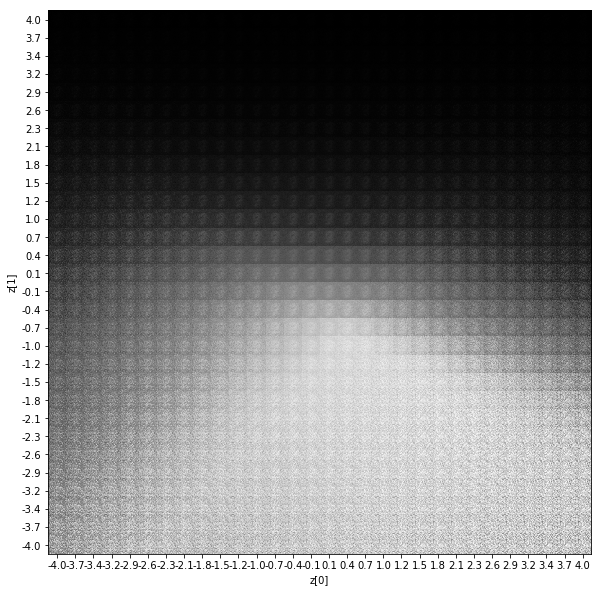

In [27]:
sdae.illustration(data=(x_test,y_test))

# Dense Variational AEs

In [23]:
class DenseVariationalAutoEncoder(AutoEncoderBase):
    def __init__(self,
                 input_dim = None,
                 latent_dim = None,
                 network_architecture = None, 
                 activation = 'relu',
                 last_layer_activation = 'sigmoid',
                 activity_regularizer = None,
                 learning_rate = 0.03,
                 batch_size = 100):
        
        super().__init__(input_dim = input_dim,
                         latent_dim = latent_dim,
                         activation = activation,
                         activity_regularizer = activity_regularizer,
                         learning_rate = learning_rate,
                         batch_size = batch_size,
                         variational = True)
        
        if network_architecture is None:
            self.network_architecture = [ [self.input_dim,self.input_dim//2,self.latent_dim],
                                          [self.latent_dim,self.input_dim//2,self.input_dim] ]
        else:
            self.network_architecture = network_architecture
        
        self.encoder_arch = self.network_architecture[0]
        self.decoder_arch = self.network_architecture[1]
        self.input_dim = self.encoder_arch[0]
        self.latent_dim = self.encoder_arch[-1] 
        self.last_layer_activation = last_layer_activation
        
        assert len(self.encoder_arch)>1,'Encoder layers have to be more than 1!'
        assert len(self.decoder_arch)>1,'Decoder layers have to be more than 1!'
        assert self.encoder_arch[0]==self.decoder_arch[-1],\
                "Input and output dimension have to be equal in encoder and decoder!"
        assert self.encoder_arch[-1]==self.decoder_arch[0],\
                "Latent layer dimension have to be equal in encoder and decoder!"

        self.input = Input(shape=(self.input_dim))
        self.encoded,self.z_mean, self.z_log_var = self._encode(self.input)
        self.decoded = self._decode(self.encoded)
        
#         self.encoder_index = len(self.encoder_arch)+2
        self.encoder_index = len(Model(self.input,self.encoded).layers)
        
        self.prepare_models()

    def _encode(self, x_in):

        x = dense_arch(x_in,
                       arch = self.encoder_arch[:-1],
                       activation = self.activation,
                       activity_regularizer = self.activity_regularizer)
        
        
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)
        encoded = Lambda(sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        return encoded, z_mean, z_log_var
    
    def _decode(self, encoded):

        decoded = dense_arch(encoded,
                             arch = self.decoder_arch,
                             activation = self.activation,
                             last_layer_activation = self.last_layer_activation,
                             activity_regularizer = self.activity_regularizer)

        return decoded
                


W1115 18:40:36.233688 139754423023424 training_utils.py:1348] Output dense_4 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_4.


Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/3
60000/60000 [==============================] - 3s 52us/sample - loss: 62.8867

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/3
60000/60000 [==============================] - 3s 43us/sample - loss: 52.4834

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/3
60000/60000 [==============================] - 3s 48us/sample - loss: 51.0533
------------------------------------------------------------------------------------------
Encoded and decoded shapes are (1, 2), (1, 784).


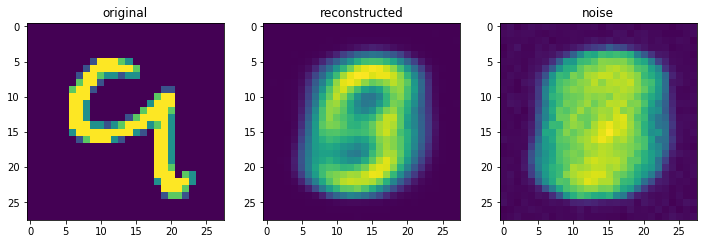

Differece between method and predicdt is 70.1368637084961.
------------------------------------------------------------------------------------------


In [6]:
vae = DenseVariationalAutoEncoder(network_architecture=[[784,100,10,2],[2,10,100,784]])
vae.check(x_train,l=28,w=28)

In [7]:
vae.train(x_train,training_epochs=10)

Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/10
60000/60000 [==============================] - 2s 41us/sample - loss: 49.3557

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/10
60000/60000 [==============================] - 3s 42us/sample - loss: 47.4875

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/10
60000/60000 [==============================] - 2s 41us/sample - loss: 46.9810

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/10
60000/60000 [==============================] - 2s 40us/sample - loss: 46.7976

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 5/10
60000/60000 [==============================] - 3s 42us/sample - loss: 46.7110

Epoch 00006: LearningRateScheduler reducing learning rate to 0.003125.
Epoch 6/10
60000/60000 [==============================] - 2s 42us/sample - loss: 46.6792

Epoch 00007: LearningRate

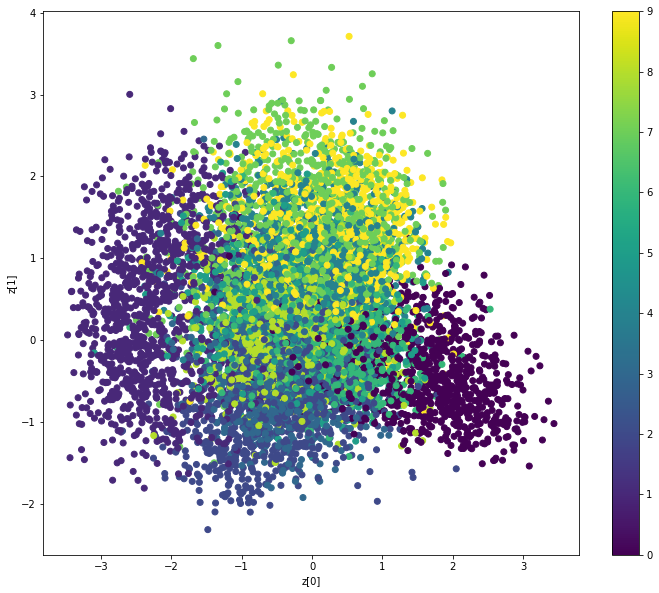

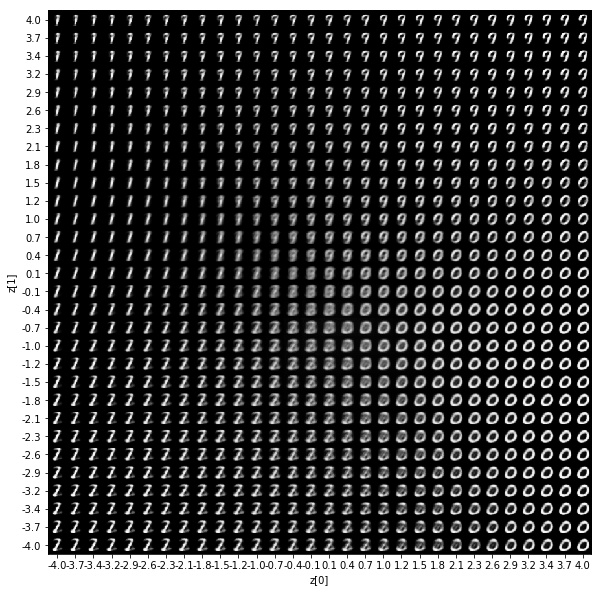

In [9]:
vae.illustration(data=(x_test,y_test))

#### Sparsity implimentation

W1115 19:02:35.816340 139754423023424 training_utils.py:1348] Output dense_56 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_56.


Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/3
60000/60000 [==============================] - 3s 52us/sample - loss: 122.2529

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/3
60000/60000 [==============================] - 3s 45us/sample - loss: 79.1534

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/3
60000/60000 [==============================] - 3s 43us/sample - loss: 77.3943
------------------------------------------------------------------------------------------
Encoded and decoded shapes are (1, 2), (1, 784).


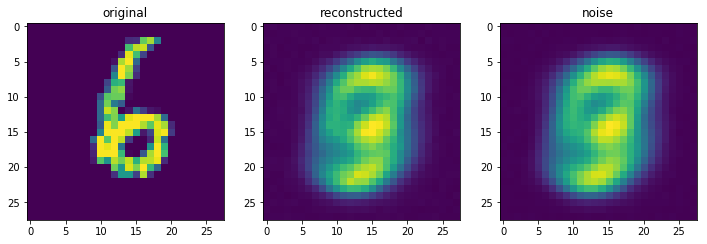

Differece between method and predicdt is 43.20597839355469.
------------------------------------------------------------------------------------------


In [29]:
vae = DenseVariationalAutoEncoder(network_architecture=[[784,100,10,2],[2,10,100,784]],
                                  activity_regularizer=l2(1))
vae.check(x_train,l=28,w=28)